In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio, display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

2025-05-14 16:36:56.392952: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747240616.583160      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747240616.639200      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load Dataset

In [2]:
def load_crema_data(data_path, max_files=1000):
    """Load CREMA-D dataset with emotion labels"""
    emotions = ['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD']
    file_paths = []
    labels = []
    
    for root, _, files in os.walk(data_path):
        for file in files[:max_files]:
            if file.endswith('.wav'):
                emotion_code = file.split('_')[2]
                if emotion_code in emotions:
                    file_paths.append(os.path.join(root, file))
                    labels.append(emotion_code)
    
    # Convert emotion codes to full names
    emotion_map = {'ANG':'angry', 'DIS':'disgust', 'FEA':'fear', 
                   'HAP':'happy', 'NEU':'neutral', 'SAD':'sad'}
    labels = [emotion_map[l] for l in labels]
    
    return file_paths, labels

data_path = "/kaggle/input/speech-emotion-recognition-en/Crema"  
file_paths, labels = load_crema_data(data_path)

In [ ]:


def explore_emotion_classes(data_path, sample_rate=22050, max_files_per_class=1):
    """
    Load and plot waveform for one sample from each emotion class in CREMA-D dataset
    
    Args:
        data_path: Path to CREMA-D dataset directory
        sample_rate: Target sampling rate (default 22050)
        max_files_per_class: Maximum number of samples to display per emotion
    """
    # CREMA-D emotion codes mapping
    emotion_map = {
        'ANG': 'Angry',
        'DIS': 'Disgust',
        'FEA': 'Fear',
        'HAP': 'Happy',
        'NEU': 'Neutral',
        'SAD': 'Sad'
    }
    
    # Create figure for plots
    plt.figure(figsize=(16, 12))
    plt.suptitle('Audio Waveforms by Emotion Class', y=1.02, fontsize=16)
    
    # Process each emotion class
    for i, (code, emotion) in enumerate(emotion_map.items()):
        # Find first matching file for this emotion
        for root, _, files in os.walk(data_path):
            for file in files:
                if file.endswith('.wav') and code in file:
                    # Load audio file
                    file_path = os.path.join(root, file)
                    y, sr = librosa.load(file_path, sr=sample_rate)
                    
                    # Create subplot
                    plt.subplot(3, 2, i+1)
                    librosa.display.waveshow(y, sr=sr, alpha=0.6)
                    plt.title(f'{emotion} (File: {file})')
                    plt.xlabel('Time (s)')
                    plt.ylabel('Amplitude')
                    plt.ylim(-1, 1)
                    
                    # Play audio in notebook (remove if not using Jupyter)
                    display(Audio(data=y, rate=sr))
                    
                    if max_files_per_class <= 1:
                        break
            else:
                continue
            break
    
    plt.tight_layout()
    plt.show()


explore_emotion_classes(data_path)

# mel spectrogram

In [17]:
def augment_audio(y, sr):
    if random.random() < 0.5:
        y = librosa.effects.pitch_shift(y, sr=sr, n_steps=random.choice([-2, -1, 1, 2]))
    if random.random() < 0.5:
        y = librosa.effects.time_stretch(y, rate=random.uniform(0.9, 1.1))
    if random.random() < 0.5:
        noise = 0.005 * np.random.randn(len(y))
        y = y + noise
    return y

In [18]:
def extract_mel_spectrogram(file_path, n_mels=128, augment=False):
    y, sr = librosa.load(file_path, sr=22050, duration=3.0)
    if len(y) < 66150:
        y = np.pad(y, (0, 66150 - len(y)), mode='constant')
    if augment:
        y = augment_audio(y, sr)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    log_S = librosa.power_to_db(S, ref=np.max)
    if log_S.shape[1] < 130:
        log_S = np.pad(log_S, ((0, 0), (0, 130 - log_S.shape[1])), mode='constant')
    else:
        log_S = log_S[:, :130]
    return log_S

In [19]:
def get_emotion_label(filename):
    emotion_map = {'NEU': 'neutral', 'HAP': 'happy', 'SAD': 'sad', 'ANG': 'angry', 'FEA': 'fearful', 'DIS': 'disgust'}
    emotion = filename.split('_')[2]
    return emotion_map.get(emotion, 'unknown')

# Load and preprocess data
data_path = "/kaggle/input/speech-emotion-recognition-en/Crema"
file_paths = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.endswith(".wav")]

features = []
labels = []
valid_paths = []

print("Extracting original mel spectrograms...")
for file_path in file_paths:
    label = get_emotion_label(os.path.basename(file_path))
    if label != 'unknown':
        mel = extract_mel_spectrogram(file_path, augment=False)
        features.append(mel)
        labels.append(label)
        valid_paths.append(file_path)

X = np.array(features)
y = np.array(labels)

# Add channel dimension if needed
if len(X.shape) == 3:
    X = X[..., np.newaxis]  # (n_samples, 128, 130, 1)

Extracting original mel spectrograms...


In [16]:
y_categorical.size

44652

In [20]:
import random
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Split data BEFORE augmentation
X_train, X_test, y_train, y_test, train_paths, test_paths = train_test_split(
    X, y_categorical, valid_paths, test_size=0.3, stratify=y_encoded, random_state=42)

print("Applying augmentation to training set...")
augmented_X = []
augmented_y = []

for i, path in enumerate(train_paths):
    mel_aug = extract_mel_spectrogram(path, augment=True)
    augmented_X.append(mel_aug)
    augmented_y.append(y_train[i])

# Ensure augmented data has same dimensions as original
augmented_X_array = np.array(augmented_X)
if len(augmented_X_array.shape) == 3:
    augmented_X_array = augmented_X_array[..., np.newaxis]  # Add channel dimension

# Combine original and augmented training data
X_train_augmented = np.concatenate([X_train, augmented_X_array])
y_train_augmented = np.concatenate([y_train, np.array(augmented_y)])

Applying augmentation to training set...


In [21]:
def mixup(X, y, alpha=0.4):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X_shuffled = X[indices]
    y_shuffled = y[indices]

    lam = np.random.beta(alpha, alpha)
    X_mix = lam * X + (1 - lam) * X_shuffled
    y_mix = lam * y + (1 - lam) * y_shuffled

    return X_mix, y_mix


In [8]:
X_train_augmented, y_train_augmented = mixup(X_train_augmented, y_train_augmented)

In [ ]:
X_train_augmented[0].shape

In [22]:
## CNN Model Architecture
def create_cnn_model(input_shape, num_classes):
    """Create a high-performance CNN model using only conv, pool, and dense layers"""
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # First Conv Block
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),
        
        # Second Conv Block
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),
        
        # Third Conv Block
        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),
        
        # Flatten and Dense Layers
        layers.Flatten(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

In [23]:
model = create_cnn_model(X_train.shape[1:], y_categorical.shape[1])
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
]

print("Training model...")
history = model.fit(X_train_augmented, y_train_augmented, validation_split=0.15, epochs=100, batch_size=32,callbacks=callbacks, verbose=1)

Training model...
Epoch 1/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 55s 148ms/step - accuracy: 0.2882 - loss: 4.5436 - val_accuracy: 0.2546 - val_loss: 4.7962 - learning_rate: 0.0010
Epoch 2/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 34s 121ms/step - accuracy: 0.3605 - loss: 3.6659 - val_accuracy: 0.3858 - val_loss: 3.2081 - learning_rate: 0.0010
Epoch 3/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 33s 119ms/step - accuracy: 0.3919 - loss: 3.1212 - val_accuracy: 0.3704 - val_loss: 2.9622 - learning_rate: 0.0010
Epoch 4/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 33s 119ms/step - accuracy: 0.4138 - loss: 2.7270 - val_accuracy: 0.2726 - val_loss: 2.9100 - learning_rate: 0.0010
Epoch 5/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 33s 120ms/step - accuracy: 0.4321 - loss: 2.5865 - val_accuracy: 0.4734 - val_loss: 2.5766 - learning_rate: 0.0010
Epoch 6/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 33s 119ms/step - accuracy: 0.4446 - loss: 2.7151 - val_accuracy: 0.3967 - val_loss: 2.6799 - learning_rate: 0.0010
Epoch 7/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 33s 1

In [ ]:
model.save("cnn_full_model2.h5")

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("cnn_full_model.h5")

In [24]:
print("Evaluating model...")
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=le.classes_))


Evaluating model...
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step

Classification Report:
              precision    recall  f1-score   support

       angry       0.70      0.72      0.71       382
     disgust       0.52      0.56      0.54       381
     fearful       0.53      0.46      0.50       381
       happy       0.59      0.53      0.56       382
     neutral       0.58      0.63      0.60       326
         sad       0.55      0.58      0.57       381

    accuracy                           0.58      2233
   macro avg       0.58      0.58      0.58      2233
weighted avg       0.58      0.58      0.58      2233



In [25]:
from sklearn.metrics import f1_score, accuracy_score
f1_weighted = f1_score(y_test_classes, y_pred_classes, average='weighted')
print(f"F1 Score (Weighted): {f1_weighted:.4f}")
acc = accuracy_score(y_test_classes, y_pred_classes)
print(f"\nAccuracy: {acc:.4f}")


F1 Score (Weighted): 0.5787

Accuracy: 0.5799


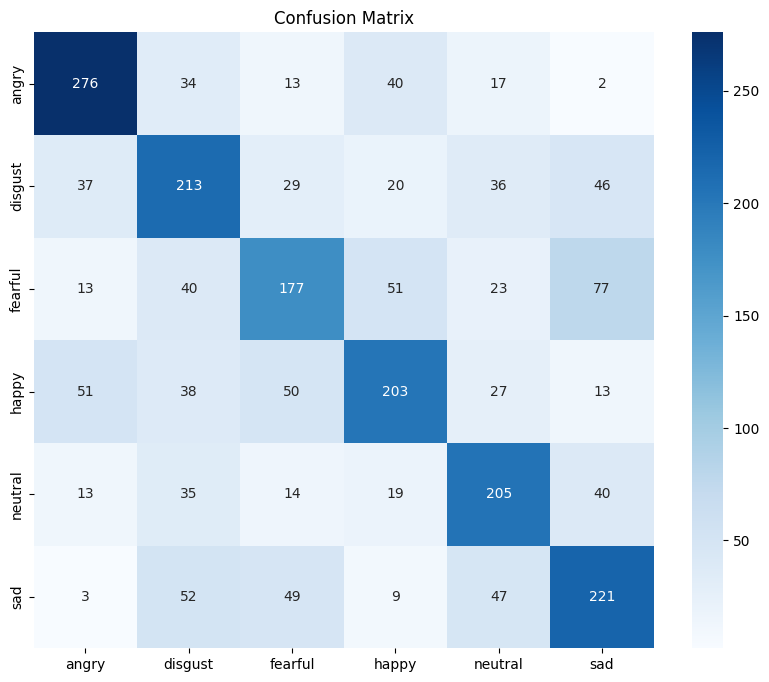

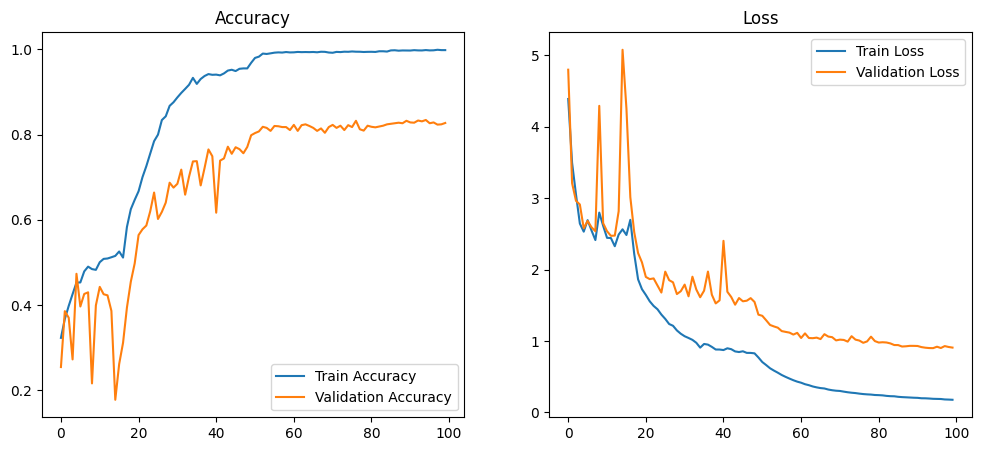

In [26]:
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()


# Time Features


In [ ]:
# Extract time-domain features 

def extract_time_features(file_path, duration=3.0, sr=22050):
    y, _ = librosa.load(file_path, sr=sr, duration=duration)
    if len(y) < int(sr * duration):
        y = np.pad(y, (0, int(sr * duration) - len(y)), mode='constant')
    frame_length = 2048
    hop_length = 512
    zcr = librosa.feature.zero_crossing_rate(y, frame_length=frame_length, hop_length=hop_length)[0]
    energy = np.array([
        np.sum(np.square(y[i:i+frame_length]))/frame_length
        for i in range(0, len(y)-frame_length+1, hop_length)
    ])
    max_len = max(len(zcr), len(energy))
    if len(zcr) < max_len:
        zcr = np.pad(zcr, (0, max_len - len(zcr)), mode='constant')
    if len(energy) < max_len:
        energy = np.pad(energy, (0, max_len - len(energy)), mode='constant')
    features = np.vstack((zcr, energy)).T
    return features

# Prepare dataset for time-domain features
print("Extracting time-domain features...")
time_features = []
time_labels = []
for file_path in file_paths:
    label = get_emotion_label(os.path.basename(file_path))
    if label != 'unknown':
        time_features.append(extract_time_features(file_path))
        time_labels.append(label)

X_time = np.array(time_features)  
y_time = np.array(time_labels)


In [ ]:
# Encode labels and split data 
le_time = LabelEncoder()
y_time_encoded = le_time.fit_transform(y_time)
y_time_cat = to_categorical(y_time_encoded)

X_time_train, X_time_test, y_time_train, y_time_test = train_test_split(
    X_time, y_time_cat, test_size=0.3, stratify=y_time_encoded, random_state=42
)

In [ ]:
# Build 1D CNN model for time-domain features 
def create_1d_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        
        layers.Conv1D(64, 5, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Dropout(0.3),  
        
        layers.Conv1D(128, 5, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Dropout(0.3),  
        
        layers.Flatten(),
        
        layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.4), 
        
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [ ]:

# Train and evaluate the 1D CNN
model_time = create_1d_cnn(X_time_train.shape[1:], y_time_cat.shape[1])
model_time.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

callbacks_time = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)
]

print("Training 1D CNN on time-domain features...")
history_time = model_time.fit(
    X_time_train, y_time_train,
    validation_split=0.05,
    epochs=50,
    batch_size=32,
    callbacks=callbacks_time,
    verbose=1
)


In [ ]:

# Evaluation and plots for time-domain model 
print("Evaluating time-domain model...")
y_time_pred = model_time.predict(X_time_test)
y_time_pred_classes = np.argmax(y_time_pred, axis=1)
y_time_test_classes = np.argmax(y_time_test, axis=1)

print("\nClassification Report (Time Domain):")
print(classification_report(y_time_test_classes, y_time_pred_classes, target_names=le_time.classes_))

cm_time = confusion_matrix(y_time_test_classes, y_time_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm_time, annot=True, fmt='d', cmap='Blues', xticklabels=le_time.classes_, yticklabels=le_time.classes_)
plt.title('Confusion Matrix (Time Domain)')
plt.show()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_time.history['accuracy'], label='Train Accuracy')
plt.plot(history_time.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy (Time Domain)')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_time.history['loss'], label='Train Loss')
plt.plot(history_time.history['val_loss'], label='Validation Loss')
plt.title('Loss (Time Domain)')
plt.legend()
plt.show()